<a href="https://colab.research.google.com/github/vbanai/ML-Technics-in-Sales-and-Marketing/blob/main/Comprehensive_ecommerce_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims at analyzing the content of an E-commerce database downloaded from Kaggle that lists purchases made by approximately 4000 customers over a period of one year. I would like to provide a useful overview for the store which can help creating a more efficient marketing strategy and boost the turnover.

In [1]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot





Import the dataset from Kaggle

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "viktorbanai" # username from the json file
os.environ['KAGGLE_KEY'] = "9431db56af1a1a63cab88b4e516a2248" # key from the json file
!kaggle datasets download -d carrie1/ecommerce-data # api copied from kaggle

 69% 5.00M/7.20M [00:00<00:00, 42.6MB/s]
100% 7.20M/7.20M [00:00<00:00, 46.1MB/s]


In [3]:
!mkdir file_destination_ecommerce_data
!unzip -u "/content/ecommerce-data.zip" -d "/content/file_destination_ecommerce_data"

Archive:  /content/ecommerce-data.zip
  inflating: /content/file_destination_ecommerce_data/data.csv  


In [ ]:
#df_initial=pd.read_csv("/content/file_destination_ecommerce_data/data.csv", encoding= 'unicode_escape')
#df_initial.head()

In [15]:
import pandas as pd
df_initial = pd.read_csv("/content/file_destination_ecommerce_data/data.csv",encoding="ISO-8859-1", 
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [ ]:
df_initial[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Data cleaning

In [16]:
#Change the format of the date to datetime
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])


In [ ]:
#Describe the dataset

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.Series(df_initial.isnull().sum(), index=tab_info.columns, name='null values (nb)'))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info = tab_info.rename(columns={'InvoiceNo': 'Invoice number'}, index={'null values (nb)': 'number of null values'})
tab_info

,Invoice number,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
number of null values,0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [17]:
#Drop Nas
df_initial.dropna(subset = ['CustomerID'], inplace = True)

In [ ]:
df_initial.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [18]:
# Sum and drop duplicates
df_initial.duplicated().sum()
df_initial.drop_duplicates(inplace = True)

1.) EXPLORING THE DATASET

A) Check the dataset, the number of the products, customers and transactions

In [8]:
print("Rows: ", df_initial.shape[0])
print("Columns: ", df_initial.shape[1])
print("\nFeatures: \n ", df_initial.columns.tolist())
print("\nMissing values:  ", df_initial.isnull().sum().values.sum())
print('\nUnique values:  \n', df_initial.nunique())

Rows:  401604
Columns:  8

Features: 
  ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Missing values:   0

Unique values:  
 InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64


In [9]:


q={
    "Product_q": len(df_initial['StockCode'].value_counts()),
    "Customer_q": len(df_initial['CustomerID'].value_counts()),
    "Transation_q": len(df_initial['InvoiceNo'].value_counts())
}
Quantities=pd.DataFrame(q, index = ['quantity'])
Quantities

,Product_q,Customer_q,Transation_q
quantity,3684,4372,22190


B) Number of products per invoices

In [10]:


temp = df_initial.groupby(by=['InvoiceNo', 'CustomerID'])
#temp.get_group('536365')['Quantity'].sum()

Number_of_products=temp['StockCode'].count().to_frame()
Number_of_products.rename({'StockCode':'Number of products'}, axis=1, inplace=True)
Number_of_products_reset= Number_of_products.reset_index()


Number_of_products_reset.loc[Number_of_products_reset['CustomerID']=='12346']
Number_of_products_reset

,InvoiceNo,CustomerID,Number of products
0,536365,17850,7
1,536366,17850,2
2,536367,13047,12
3,536368,13047,4
4,536369,13047,1
...,...,...,...
22185,C581484,16446,1
22186,C581490,14397,2
22187,C581499,15498,1
22188,C581568,15311,1


C) Number of invoices

In [11]:


len(Number_of_products_reset['Number of products'])

22190

2.) SALES AND REVENUE ANALYSIS

A) Sorting Customers

In [ ]:

df_initial.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


B) Check and drop the cancellations

In [ ]:


Number_of_products_reset['Cancellation'] = Number_of_products_reset['InvoiceNo'].apply(lambda x:int('C' in x))
Number_of_products_reset

,InvoiceNo,CustomerID,Number of products,Cancellation
0,536365,17850,7,0
1,536366,17850,2,0
2,536367,13047,12,0
3,536368,13047,4,0
4,536369,13047,1,0
...,...,...,...,...
22185,C581484,16446,1,1
22186,C581490,14397,2,1
22187,C581499,15498,1,1
22188,C581568,15311,1,1


In [ ]:
Cancellation_number=len(Number_of_products_reset[Number_of_products_reset['Cancellation']==1])
Cancellation_number

3654

In [ ]:
df_initial2=df_initial.copy(deep=True)

#InvoiceNo of a cancelled item starts with C:
df_initial2.loc[df_initial2['InvoiceNo']=='C541433']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


In [ ]:
# Making  a cancellation column
df_initial2["Cancellation"]=df_initial2['InvoiceNo'].apply(lambda x: int("C" in x))


In [ ]:
#Number of the cancelled items
len(df_initial2.loc[df_initial2["Cancellation"]==1])

8872

In [ ]:
#Number of the cancelled invoices:
f=df_initial2.loc[df_initial2["Cancellation"]==1].groupby(["InvoiceNo"]).count()
len(f)

3654

In [ ]:
# Dropping cancellations and check the min and max amount per stock code


df_initial2=df_initial2.drop(df_initial2.index[df_initial2["Cancellation"] == 1])

df_initial2['Total amount']=df_initial2['Quantity'] * df_initial2['UnitPrice']
print("min: ", min(df_initial2['Total amount']), "            max: ", max(df_initial2['Total amount']))
df_initial2.loc[df_initial2['Total amount']==168469.6]

min:  0.0             max:  168469.6


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Total amount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,0,168469.6


C) Describe the transactions

Creating Choropleth to check the geographical distribution of the transactions </br>
Map version 1 (by invoice volume)

In [ ]:
#1 method (Some countries are not showed for example South Africa, maybe because the country names in the preset libary is different to the current database's country names)

temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()   #maybe there is another method to get the value in multiindexing
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

fig=go.Figure(data = [data], layout = layout)
fig.show(renderer="colab")

#Alternative solution can be:
#Create a list of country names
#Create a function with `df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == ""].index, 'Country'] = ''`
#Make a loop over the list using the function

Map version 2 (by line items)


In [ ]:
#2. method (Some countries in the database are not in the downloaded map libary, but in following method I can control and check the countries)
# I uploaded a geojson file from my computer

import json
world_map=json.load(open("/content/custom.geo.json", "r"))  # I have uploaded a downloaded geo.json file
world_map['features'][2]['properties']  #I need admin 

In [ ]:
country_id={}  
for feature in world_map['features']:
  feature['id']=feature['properties']['brk_a3']
  country_id[feature['properties']['admin']]=feature['id']  #create pairs for example  'Czech Republic':'CZE'

#I have to rename some countires in the dataset to match the json file naming
#for example in the json file Hong Kong or Singapure is not indicated just China, 
#so in the dataset I changed this two country name to China, to see the geographical distribution somehow

df_initial_map=df_initial.copy(deep=True)

df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "EIRE"].index, 'Country'] = 'Ireland'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Channel Islands"].index, 'Country'] = 'France'
df_initial_map.loc[df_initial_map['Country'] == "Channel Islands"].index
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Bahrain"].index, 'Country'] = 'Saudi Arabia'
df_initial_map.loc[df_initial_map['Country'] == "Bahrain"].index
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Hong Kong"].index, 'Country'] = 'China'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Singapore"].index, 'Country'] = 'China'
df_initial_map.drop(df_initial_map[df_initial_map['Country'] == "Unspecified"].index, inplace = True)
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "USA"].index, 'Country'] = 'United States of America'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "European Community"].index, 'Country'] = 'Germany'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "Malta"].index, 'Country'] = 'Italy'
df_initial_map.loc[df_initial_map.loc[df_initial_map['Country'] == "RSA"].index, 'Country'] = 'South Africa'

In [ ]:

!pip install plotly==4.5. 0
import plotly.express as px

df_initial_map['id']=df_initial_map['Country'].apply(lambda x:country_id[x])  # create a new country ID coloumn

countries = df_initial_map['Country'].value_counts()
countries=countries.to_frame()
countries.rename(columns={'Country':'Number of orders'}, inplace=True)
countries['Country'] = countries.index
countries.reset_index(inplace=True)
del countries['index']
countries['id']=countries['Country'].apply(lambda x:country_id[x])
countries

In [ ]:
import numpy as np
countries['Number of ordersScale']=np.log10(countries['Number of orders'])  # because of the outliers we have to normalize the data somehow to have clearer plot
fig=px.choropleth(countries, locations='id', geojson=world_map, color="Number of ordersScale")
fig.show(renderer="colab")

In [ ]:
#Purchased amount by custmomers
df_purchased_amount=df_initial2.pivot_table(values="Total amount", index="CustomerID", aggfunc='sum')


In [ ]:
df_initial3=df_initial2.groupby(by=["CustomerID"])

In [ ]:
#How many invoice belongs to one customer and what is the total amount of them

df_initial_purchased_amount=df_initial3["Total amount"].sum().to_frame()
df_initial_purchased_amount["Invoice count"]=df_initial3["InvoiceNo"].count()
df_initial_purchased_amount


,Total amount,Invoice count
CustomerID,,
12346,77183.60,1
12347,4310.00,182
12348,1797.24,31
12349,1757.55,73
12350,334.40,17
...,...,...
18280,180.60,10
18281,80.82,7
18282,178.05,12


In [ ]:
# see the same but without the outlier total amounts, say under 10000USD
underonethousand=df_initial_purchased_amount.loc[df_initial_purchased_amount["Total amount"]<10000]
underonethousand

,Total amount,Invoice count
CustomerID,,
12347,4310.00,182
12348,1797.24,31
12349,1757.55,73
12350,334.40,17
12352,2506.04,85
...,...,...
18280,180.60,10
18281,80.82,7
18282,178.05,12


In [ ]:
#Customer having the max total amount and customer having the most invoices 

table=df_initial_purchased_amount.loc[df_initial_purchased_amount["Total amount"]==max(df_initial_purchased_amount["Total amount"])]
table=table.append(df_initial_purchased_amount.loc[df_initial_purchased_amount["Invoice count"]==max(df_initial_purchased_amount["Invoice count"])])
table

,Total amount,Invoice count
CustomerID,,
14646,280206.02,2080
17841,40519.84,7676


In [ ]:
#Total amount by invoices (without the cancelled invoices)

temp=df_initial2.groupby(by=['CustomerID', 'InvoiceNo' ])


Amount_by_invoices=temp['Total amount'].sum().to_frame()

#Customer having the most valuable invoice

Amount_by_invoices.loc[Amount_by_invoices["Total amount"]==max(Amount_by_invoices["Total amount"])]

,,Total amount
CustomerID,InvoiceNo,
16446,581483,168469.6


In [ ]:

# Presenting the distribution of the purchased amounts


price_range = [0, 1000, 80000, 140000, 170000]

count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = Amount_by_invoices[(Amount_by_invoices['Total amount'] < price) &
                       (Amount_by_invoices['Total amount'] > price_range[i-1])]['Total amount'].count()
    count_price.append(val)

In [ ]:
count_price

[17218, 1312, 0, 1]

In [ ]:
import plotly           
import plotly.express as px
import plotly.io as pio




#plt.rc('font', weight='bold')
#f, ax = plt.subplots(figsize=(11, 6))
colors = [ 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{} USD'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
          

sizes  = count_price

#p for p in count_prize

pie_chart = px.pie(
    
        values=count_price,
        names=labels,
        color=colors,                     
       
        labels={"state":"the State"},      
        title='Distribution of the invoice amounts',     
        template='presentation',           
                                          
        width=800,                          
        height=600,                         
        hole=0.2,                          
        )

pio.show(pie_chart, renderer="colab")

C) Revenue analysis

In [ ]:

df_initial2['year_month']=df_initial2['InvoiceDate'].dt.to_period('M')

In [ ]:
L=['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
P=['year']
df_initial2=df_initial2.join(pd.concat((getattr(df_initial2['InvoiceDate'].dt, i).rename(i) for i in L), axis=1), lsuffix='_left', rsuffix='_right')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
df_initial2.dayofweek=df_initial2.dayofweek+1

In [ ]:
df_initial2.dayofweek.unique()

array([3, 4, 5, 7, 1, 2])

Text(0.5, 1.0, 'Number of Orders for differenet Customers')

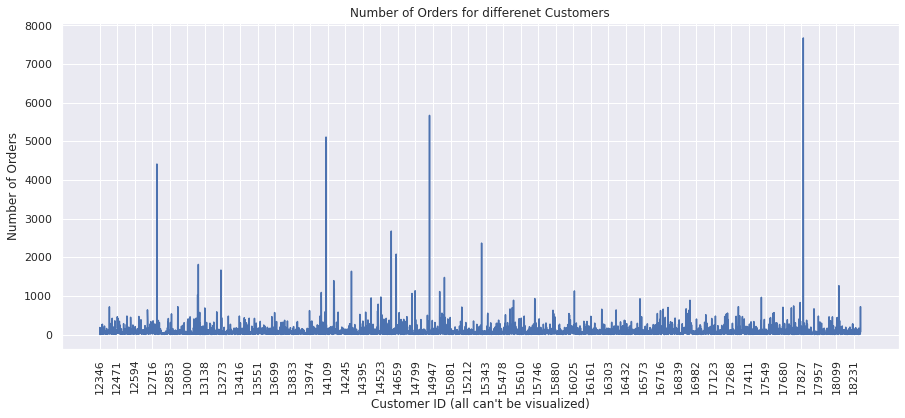

In [ ]:
#Visualizing No. of Sales for all Customers
sns.set()
orders=df_initial2.groupby(by=['CustomerID', 'Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel("Customer ID (all can't be visualized)")
plt.ylabel('Number of Orders')
plt.xticks(np.arange(0, len(orders)+1, 100))
plt.xticks(rotation=90)

plt.title('Number of Orders for differenet Customers')

Text(0.5, 1.0, 'Money Spent by Differenet Customers')

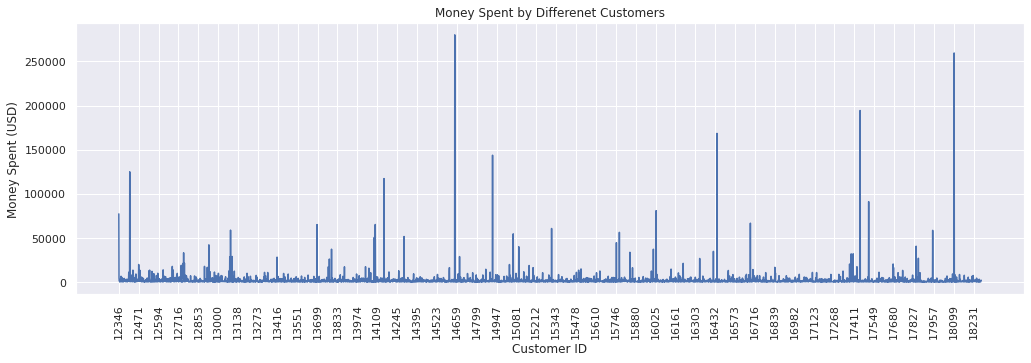

In [ ]:
#Visualizing money spent by all customers
money_spent=df_initial2.groupby(by=['CustomerID', 'Country'], as_index=False)['Total amount'].sum()

plt.subplots(figsize=(17,5))
plt.plot(money_spent.CustomerID, money_spent['Total amount'])
plt.xlabel("Customer ID")
plt.ylabel('Money Spent (USD)')
plt.xticks(np.arange(0, len(orders)+1, 100))
plt.xticks(rotation=90)
plt.title('Money Spent by Differenet Customers')

In [ ]:
timeindex=df_initial2.set_index("InvoiceDate")
timeindex.year_month.unique()

<PeriodArray>
['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
 '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12']
Length: 13, dtype: period[M]

In [ ]:
weekly_revenue=df_initial2.groupby(by=['year_month', 'dayofweek']).sum()['Total amount'].to_frame()
weekly_revenue.index

In [ ]:
weekly_revenue.index

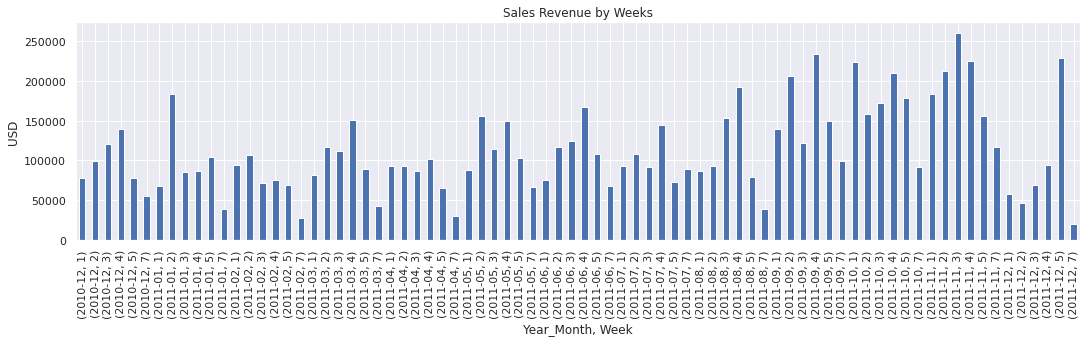

In [ ]:
weekly_revenue.plot(kind="bar", figsize=(18,4), legend=False, title="Sales Revenue by Weeks", xlabel="Year_Month, Week", ylabel='USD')

[Text(0, 0, 'December 2010'),
 Text(0, 0, 'January 2011'),
 Text(0, 0, 'February 2011'),
 Text(0, 0, 'March 2011'),
 Text(0, 0, 'April 2011'),
 Text(0, 0, 'May 2011'),
 Text(0, 0, 'June 2011'),
 Text(0, 0, 'July 2011'),
 Text(0, 0, 'August 2011'),
 Text(0, 0, 'September 2011'),
 Text(0, 0, 'Oktober 2011'),
 Text(0, 0, 'November 2011'),
 Text(0, 0, 'December 2011')]

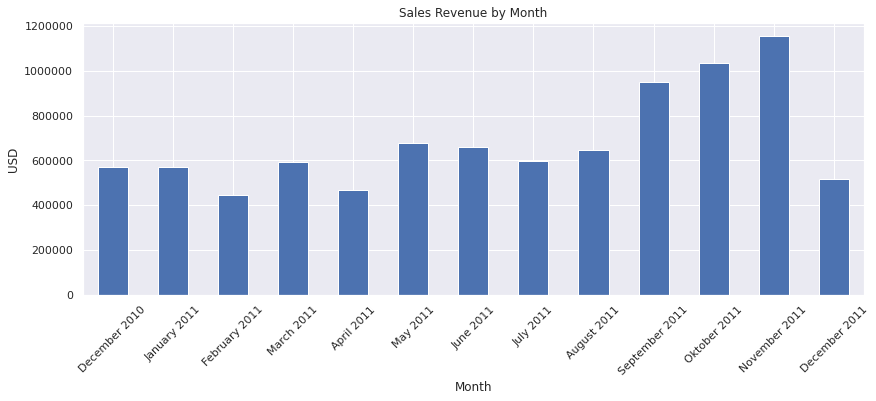

In [ ]:
sns.set()
plt.ticklabel_format(style='plain', axis='y')
ax=df_initial2.groupby('year_month').sum()["Total amount"].plot(kind="bar", figsize=(14,5), legend=False, title="Sales Revenue by Month", xlabel="Month", ylabel='USD')
ax.set_xticklabels(("December 2010", "January 2011", "February 2011", "March 2011", "April 2011", "May 2011", "June 2011", "July 2011", "August 2011", "September 2011", "Oktober 2011", "November 2011", "December 2011"), rotation=45)

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Sunday')]

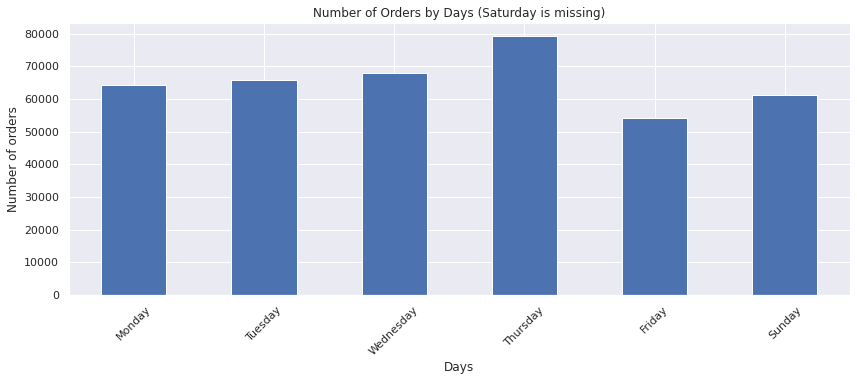

In [ ]:
sns.set()
plt.ticklabel_format(style='plain', axis='y')
ax=df_initial2.groupby(['dayofweek']).count()['InvoiceNo'].plot(kind="bar", figsize=(14,5), legend=False, title="Number of Orders by Days (Saturday is missing)", xlabel="Days", ylabel='Number of orders')
ax.set_xticklabels(("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sunday"), rotation=45)

Detect and analyse the loyal customers</br>
  I consider customer to be loyal if he/she has minimum two transactions per month

In [ ]:
#Monthly volume of customers 1 method
df_initial2.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()

In [ ]:
#2. alternative method

AllCustomer_check=pd.DataFrame(df_initial2.groupby(by=['year_month', 'CustomerID']).nunique()['InvoiceNo'])
AllCustomer_check=pd.DataFrame(AllCustomer_check.index.to_frame()).rename(columns = {'year_month': 'YM', 'CustomerID':'CI'})
AllCustomer_check.groupby(by=['YM']).nunique()['CI']


In [ ]:
#3. alternative method
AllCustomer_check=pd.DataFrame(df_initial2.groupby(by=['year_month', 'CustomerID']).nunique()['InvoiceNo'])
MonthlyCustomerVolume=AllCustomer_check.groupby(by=['year_month']).count()['InvoiceNo']


In [ ]:
#Monthly revenue
AllCustomer_check_rev=df_initial2.groupby(by=['year_month']).sum()['Total amount']

In [ ]:
#Volume of the loyal customers per month(purchase minimum twice per month)
Returning_Customers=AllCustomer_check.loc[AllCustomer_check['InvoiceNo']>1].groupby(by=['year_month']).count()['InvoiceNo']


In [ ]:
# Monthly revenue generated by loyal customers
Returning_Customers_Rev=df_initial2.groupby(by=['year_month', 'CustomerID', 'InvoiceNo']).sum()['Total amount']
Returning_Customers_Rev1=pd.DataFrame(Returning_Customers_Rev.reset_index())
Returning_Customers_Rev2=pd.DataFrame(Returning_Customers_Rev1.groupby(["year_month", "CustomerID"]).agg({'InvoiceNo':'count', 'Total amount':'sum'}).reset_index())
Returning_Customers_Rev3=Returning_Customers_Rev2.loc[Returning_Customers_Rev2['InvoiceNo']>1].groupby('year_month').sum()['Total amount']

In [ ]:
monthlyvolumeratio=(Returning_Customers/MonthlyCustomerVolume)*100


([<matplotlib.axis.XTick at 0x7f8345e46ad0>,
 [Text(0, 0, '12.2010'),
  Text(0, 0, '01.2011'),
  Text(0, 0, '02.2011'),
  Text(0, 0, '03.2011'),
  Text(0, 0, '04.2011'),
  Text(0, 0, '05.2011'),
  Text(0, 0, '06.2011'),
  Text(0, 0, '07.2011'),
  Text(0, 0, '08.2011'),
  Text(0, 0, '09.2011'),
  Text(0, 0, '10.2011'),
  Text(0, 0, '11.2011'),
  Text(0, 0, '12.2011')])

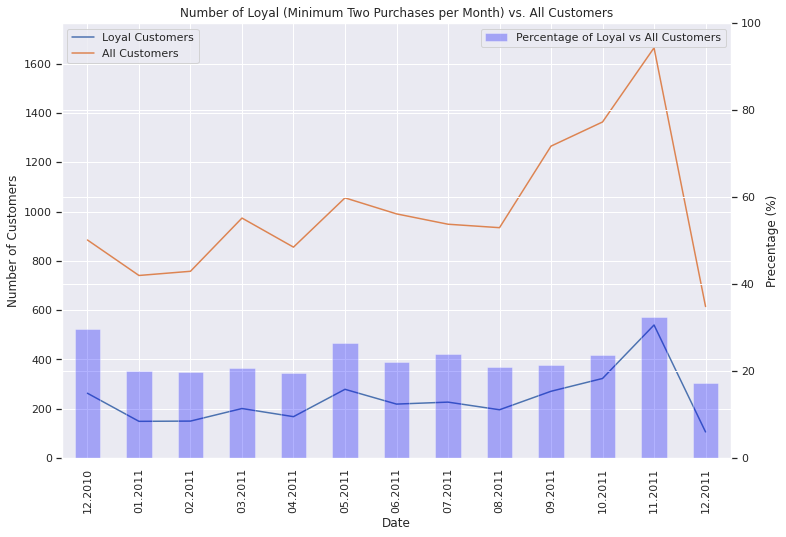

In [ ]:
ax=pd.DataFrame(Returning_Customers.values).plot(figsize=(12,8))
pd.DataFrame(MonthlyCustomerVolume.values).plot(ax=ax, grid=True)
ax2=pd.DataFrame(monthlyvolumeratio.values).plot(kind="bar", ax=ax, grid=True, secondary_y=True, color='blue', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Loyal (Minimum Two Purchases per Month) vs. All Customers')

ax2.set_ylabel('Precentage (%)')

ax.legend(['Loyal Customers', 'All Customers'])
ax2.legend(['Percentage of Loyal vs All Customers'], loc='upper right')

ax.set_ylim([0, MonthlyCustomerVolume.values.max()+100])
ax2.set_ylim([0, 100])

plt.xticks(range(len(Returning_Customers.index)), [x.strftime('%m.%Y') for x in Returning_Customers.index], rotation=45)

In [ ]:
monthlyrevenueratio=(Returning_Customers_Rev3/AllCustomer_check_rev)*100

([<matplotlib.axis.XTick at 0x7f834554eb50>,
 [Text(0, 0, '12.2010'),
  Text(0, 0, '01.2011'),
  Text(0, 0, '02.2011'),
  Text(0, 0, '03.2011'),
  Text(0, 0, '04.2011'),
  Text(0, 0, '05.2011'),
  Text(0, 0, '06.2011'),
  Text(0, 0, '07.2011'),
  Text(0, 0, '08.2011'),
  Text(0, 0, '09.2011'),
  Text(0, 0, '10.2011'),
  Text(0, 0, '11.2011'),
  Text(0, 0, '12.2011')])

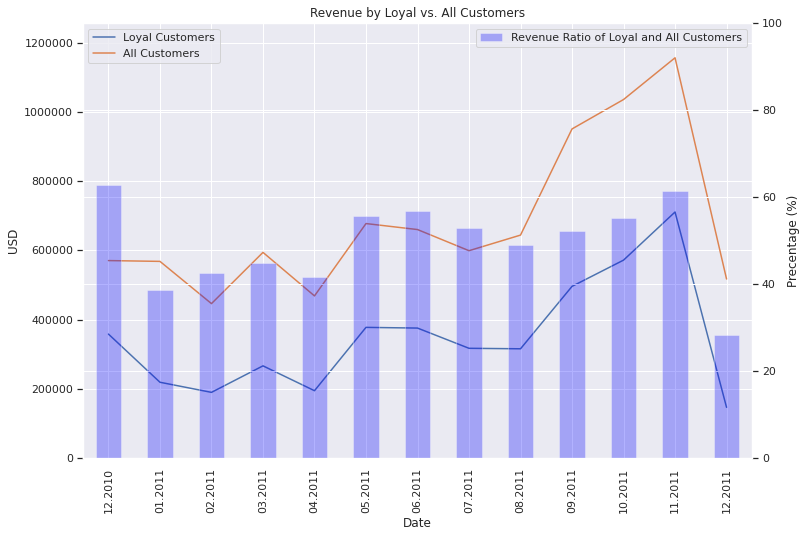

In [ ]:
ax=pd.DataFrame(Returning_Customers_Rev3.values).plot(figsize=(12,8))
ax.ticklabel_format(style='plain')
pd.DataFrame(AllCustomer_check_rev.values).plot(ax=ax, grid=True)
ax2=pd.DataFrame(monthlyrevenueratio.values).plot(kind="bar", ax=ax, grid=True, secondary_y=True, color='blue', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax.set_title('Revenue by Loyal vs. All Customers')

ax2.set_ylabel('Precentage (%)')

ax.legend(['Loyal Customers', 'All Customers'])
ax2.legend(['Revenue Ratio of Loyal and All Customers'], loc='upper right')

ax.set_ylim([0, max(AllCustomer_check_rev.values)+100000])
ax2.set_ylim([0, 100])

plt.xticks(range(len(Returning_Customers_Rev3.index)), [x.strftime('%m.%Y') for x in Returning_Customers_Rev3.index], rotation=45)

We can see that the loyal customers are valuable for the company as the revenue ratio is much higher than the ratio of number of loyal and all customers. So they constitue higher chunk of the annual revenue for the online store compared to normal customers. The next technics I will use: SEGMENTATION, TEXT MINING, MARKET BASKET ANALYSIS can help us to understand the buying patterns better, and establish loyality.

Check the yearly and quarterly sales amount, purchasing activity by Customers 

In [37]:
df_initial_sum=df_initial.loc[df_initial.Quantity>0]
df_initial_sum=df_initial_sum.loc[df_initial_sum.InvoiceDate<'2011-12-01']
df_initial_sum['Sales']=df_initial_sum['Quantity']*df_initial_sum['UnitPrice']


orders_df=df_initial_sum.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum, 'InvoiceDate': max})

def mean(x):
	return x.mean()

def purchase_count(x):
	return x.count()

def purchase_duration_in_days(x):
	return (x.max()-x.min()).days

def pruchase_frequency_in_days(x):
	return(x.max()-x.min()).days/x.count()

summary_df=orders_df.reset_index().groupby("CustomerID").agg({
	'Sales':[min, max, sum, mean, purchase_count],
	'InvoiceDate': [min, max, purchase_duration_in_days, pruchase_frequency_in_days]})

Yearly (2011)

In [38]:
summary_df

Sales  ...                InvoiceDate
                 min  ... pruchase_frequency_in_days
CustomerID            ...                           
12346       77183.60  ...                   0.000000
12347         382.52  ...                  54.500000
12348         227.44  ...                  70.500000
12349        1757.55  ...                   0.000000
12350         334.40  ...                   0.000000
...              ...  ...                        ...
18280         180.60  ...                   0.000000
18281          80.82  ...                   0.000000
18282         100.21  ...                   0.000000
18283           1.95  ...                  21.800000
18287          70.68  ...                  52.666667

[4298 rows x 9 columns]

Quarterly

In [41]:
# Summary quarterly
quarter="3M"
data_df=orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=quarter)]).agg({
	'Sales':[sum, mean, purchase_count]})

In [42]:
data_df

Sales                             
                             sum          mean purchase_count
CustomerID InvoiceDate                                       
12346      2011-03-31   77183.60  77183.600000            1.0
12347      2010-12-31     711.79    711.790000            1.0
           2011-03-31     475.39    475.390000            1.0
           2011-06-30    1018.77    509.385000            2.0
           2011-09-30     584.91    584.910000            1.0
...                          ...           ...            ...
18283      2011-06-30     497.34    124.335000            4.0
           2011-09-30     274.79     91.596667            3.0
           2011-12-31     750.70    150.140000            5.0
18287      2011-06-30     765.28    765.280000            1.0
           2011-12-31    1072.00    536.000000            2.0

[9220 rows x 3 columns]

3.) SEGMENTATION

</br>
I would like to create consumer clusters on the basis of how many invoices (say one invoice means one shopping) one customer has and what are the total value of the invoices per customer. In this way we can assume how loyal and satisfied a customer can be, how often and how much amount it spent in the store. The dataset doesn't provide enough data to create marketing strategy for the created clusters.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
sns.set()

In [ ]:
#Scaling
X_scaled=preprocessing.scale(df_initial_purchased_amount)


In [ ]:
sse = []  #sum of squarred error
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    sse.append(km.inertia_)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster

silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scaled)
    silhouette[i] = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')

100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Text(0.5, 0, 'Number of Clusters')

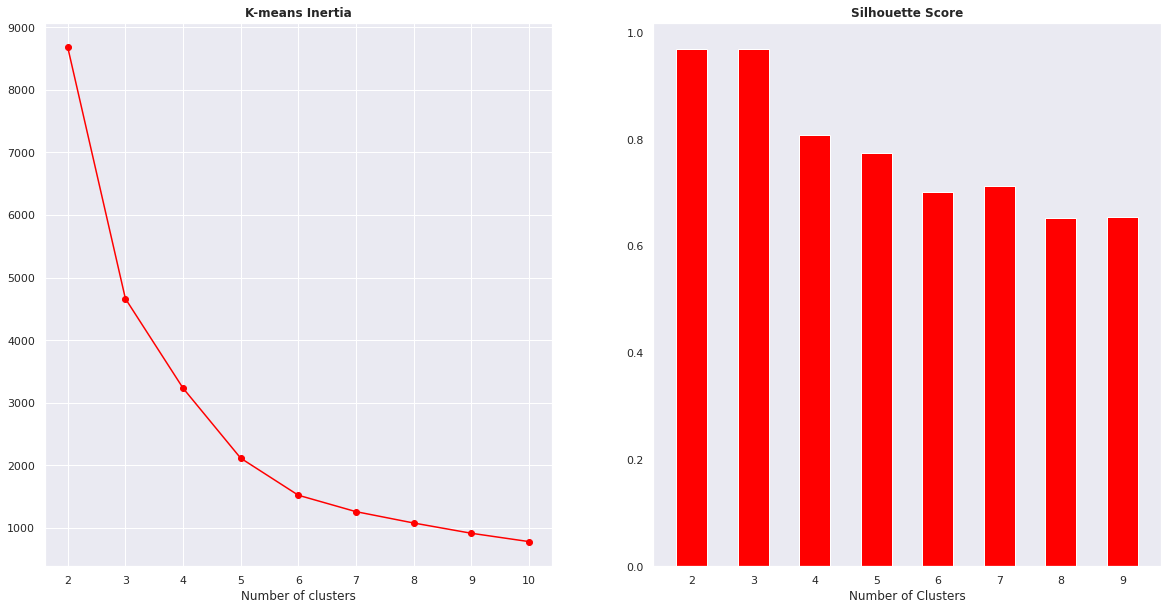

In [ ]:
#Plotting Elbow and Silhouette Graphs to check the optimal clusters to be created

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.plot(range(2,len(k_rng)+2), sse, marker='o',color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'red',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Number of Clusters')

In [ ]:

km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(X_scaled)


In [ ]:
#Try to draw the centroid, but unfortunately it is not precise in this case so I skip it

non_transformed_df=df_initial_purchased_amount[["Invoice count", "Total amount"]].values
km2 = KMeans(n_clusters=3)
y_predicted2 = km2.fit_predict(non_transformed_df)
centroids=km2.cluster_centers_


Text(0.5, 1.0, 'Segmenting the full dataset with high outlier values')

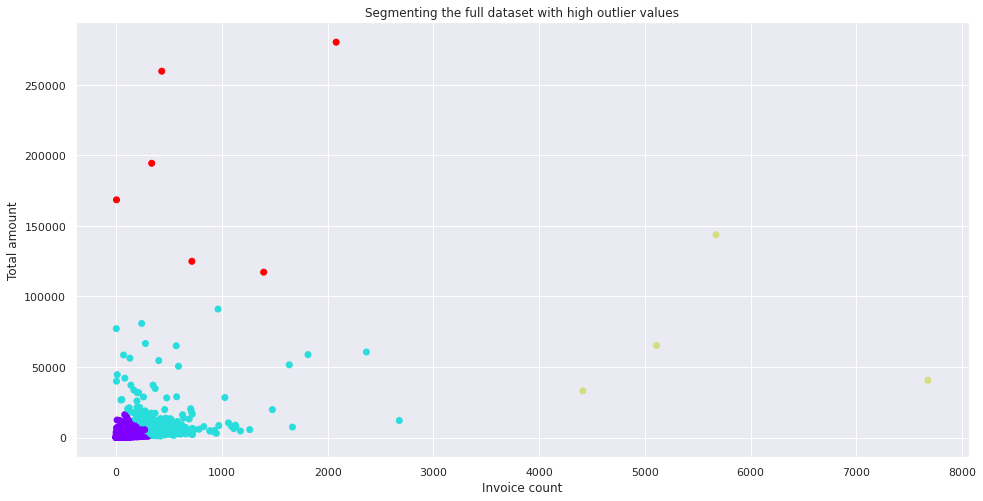

In [ ]:
# I create four clusters instead 3 which is recommended by the Silhouette Score

df_initial_purchased_amount['Clusters'] = y_predicted.tolist()
plt.figure(figsize=(16,8))
plt.scatter(df_initial_purchased_amount['Invoice count'], df_initial_purchased_amount['Total amount'], c=df_initial_purchased_amount['Clusters'], cmap='rainbow')
#plt.scatter(centroids[:,0],centroids[:,1],color='purple',marker='*', s=300, label='centroid')
plt.xlabel('Invoice count')
plt.ylabel("Total amount")
plt.title("Segmenting the full dataset with high outlier values")


Text(0.5, 1.0, 'Segmentation under 10000 USD total value')

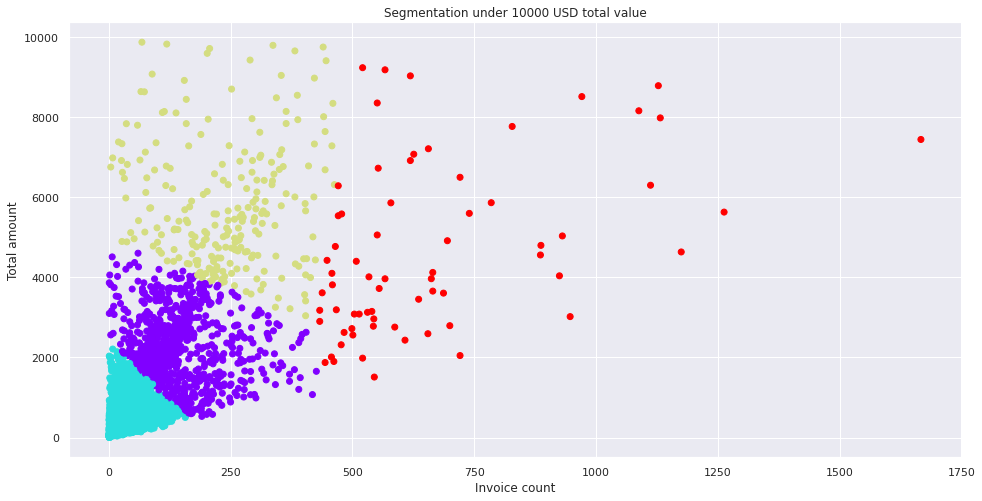

In [ ]:

underonethousand_c=underonethousand.copy(deep=True)
X_scaled2=preprocessing.scale(underonethousand_c)
km3 = KMeans(n_clusters=4)
y_predicted = km3.fit_predict(X_scaled2)




underonethousand_c['Clusters'] = y_predicted.tolist()
plt.figure(figsize=(16,8))
plt.scatter(underonethousand_c['Invoice count'], underonethousand_c['Total amount'], c=underonethousand_c['Clusters'], cmap='rainbow')
plt.xlabel('Invoice count')
plt.ylabel("Total amount")
plt.title("Segmentation under 10000 USD total value")

Normally marketing should focus on how to move consumers to a higher quality cluster. In this dataset it is hard to analyse the clusters indepth  and gain deeper insight into factors like loyalty, satisfaction etc., which play important role in the decision making process. We can perform market basket analysis and text mining on this dataset to help boosting the sales figures. According to the cluster above we can say, that the shop should propel normal and loyal customers in green and purple clusters to gold and red clusters.

4.) TEXT MINING</br>
</br>
In this section I would like to find popular product categories based on the line item descriptions.


- Finding the words most frequently appear in the descriptions

In [ ]:


# Counting and splitting the descriptions to be adequate for text normalization 

t=df_initial.Description.value_counts().to_frame()
t=t.reset_index()
t=t.rename(columns={'index': 'Description', 'Description':'Sum'})

t=t.Description.str.split(" ")

tt=[]
for i in t:
  a=[item for item in i if not item.isdigit() and item!='' ] # elimination of single numbers
  tt.append(a)

total_description=df_initial.Description.str.split(" ").to_list()
total_description_list0=[x for x in total_description]

total_description_list=[]
for i in total_description_list0:
  inter=[]
  for p in i:
    if p.isdigit()==False and p!='':
      inter.append(p)
  total_description_list.append(inter)






In [ ]:
# text normalization (using Lancaster Stemmer, Stopword dictionary, making all words lower cased 
#                           and stop character repetition)

import re

from nltk.stem.snowball import SnowballStemmer
snoball_stemmer=SnowballStemmer("english")
from nltk.stem import PorterStemmer, LancasterStemmer
porter_stemmer=PorterStemmer()
lancaster_stemmer=LancasterStemmer()

from nltk.corpus import stopwords  #stopword has no special meanings and it is better to remove them
nltk.download("stopwords")
stop_words=set(stopwords.words('english'))


preps=['above', 'across', 'against', 'along', 'among', 'around', 'at','i', "+", "-" 
'before', 'behind', 'below', 'beneath', 'beside', 'between', 'by', 
'down', 'from', 'in', 'into', 'near', 'of', 'off', 'or', 'on', 'to', 'toward', 'under', 'upon', 'with', 'and', 'within']



optimized_total_list=[]

for list in total_description_list:
  inter=[]
  for word in list:
    if word.lower() not in preps and word.lower() not in stop_words:      
        word=word.lower() # making all word lower cased
        word=re.sub(r'(.)\1+', r'\1\1', word) # Stopping character repetition
        word =word.replace(')', '')
        word = word.replace('(', '')  # remove )
        inter.append(snoball_stemmer.stem(word))    #SnowballStemmer worked was the mildest on this words 
  optimized_total_list.append(inter)

pd_optimized_list=pd.DataFrame(optimized_total_list)
count=pd_optimized_list.stack().value_counts()  # count all wordoccurance in the dataset

     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Creating Pandas Dataset with the 50 Most Frequent Words in The Product Descriptons

Count=pd.DataFrame(count, columns=['Number of Occurences'])
Count=Count.reset_index()
Count=Count.rename(columns={'index': 'Words'})
Count=Count.sort_values(by=['Number of Occurences'], ascending=False)
Count=Count[:50]



In [ ]:
# Creating Pandas Dataset with the 50 Less Frequent Words in The Product Descriptons

Count2=pd.DataFrame(count, columns=['Number of Occurences'])
Count2=Count2.reset_index()
Count2=Count2.rename(columns={'index': 'Words'})
Count2=Count2.sort_values(by=['Number of Occurences'], ascending=False)
Count2=Count2[-50:]

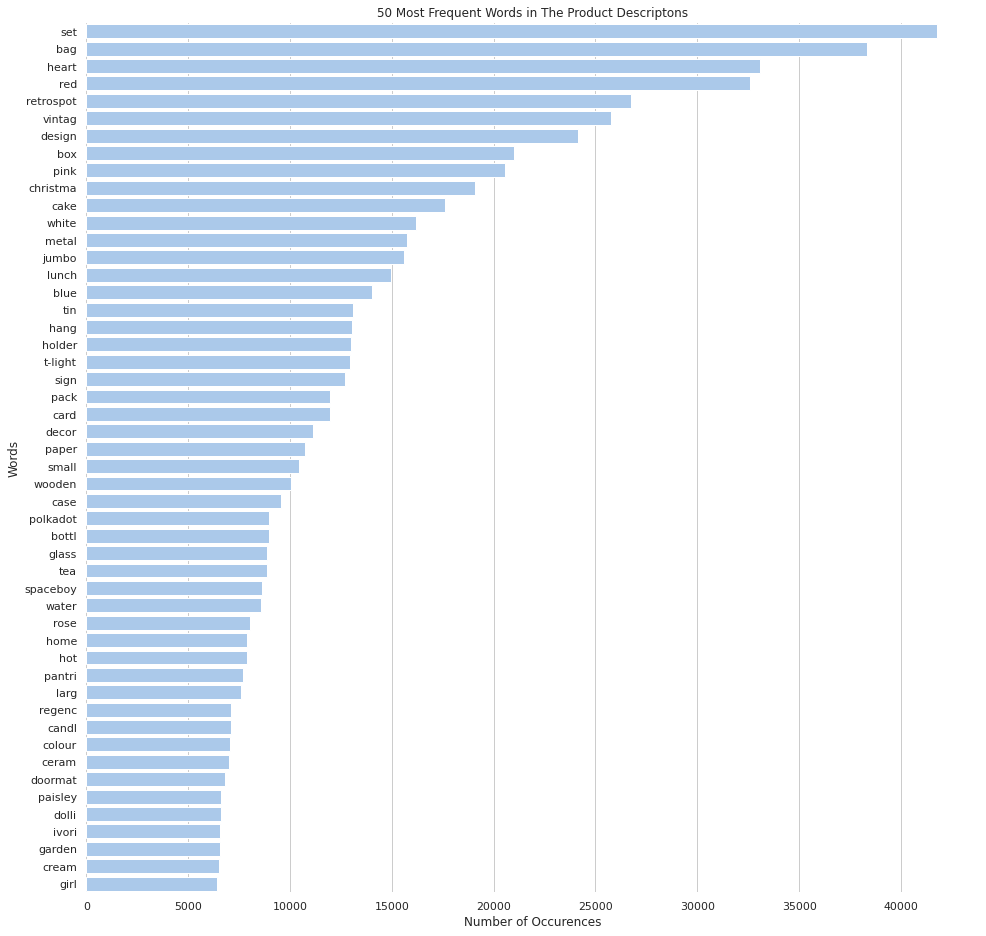

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 16))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x=Count["Number of Occurences"], y=Count.Words, data=Count, color="b").set_title("50 Most Frequent Words in The Product Descriptons")
sns.despine(left=True, bottom=True)

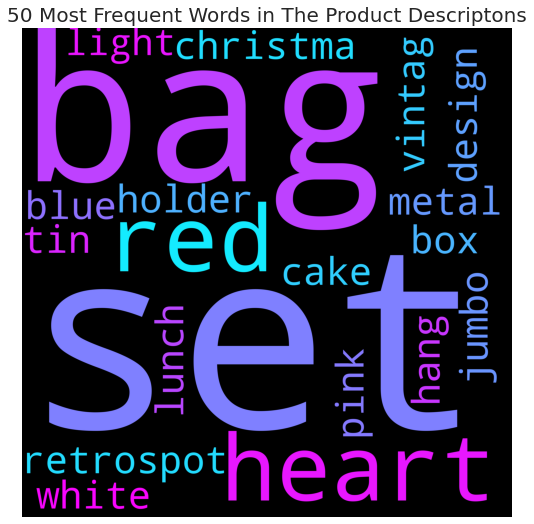

In [ ]:
from wordcloud import WordCloud


wordcloud = WordCloud(width = 6000,  height = 6000, max_words = 20, colormap='cool').generate(str(Count.Words))
plt.figure(figsize=(32, 9))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("50 Most Frequent Words in The Product Descriptons",fontsize = 20)
plt.show()

In [ ]:
#Check the most frequent word pairs

wordlist=[x for x in Count.Words]

from itertools import combinations
wordcombinations=[x for x in combinations(wordlist,2)]

wordcomb=pd.DataFrame(wordcombinations)

optimized_total_list_pd=pd.DataFrame(optimized_total_list)  
optimized_total_list_pd0 = optimized_total_list_pd.fillna(value='#')

optimized_total_list_pd0["joined"]=optimized_total_list_pd0[0]+optimized_total_list_pd0[1]+optimized_total_list_pd0[2]+optimized_total_list_pd0[3]+optimized_total_list_pd0[4]+optimized_total_list_pd0[5]+optimized_total_list_pd0[6]

def get_sum(a, b):
  sum=optimized_total_list_pd0['joined'].str.contains(a and b).sum()
  return sum

wordcomb["Sum"]=wordcomb[[0, 1]].apply(lambda x: get_sum(x[0], x[1]), axis=1)

In [ ]:
most_frequesnt_wordpairs=wordcomb.sort_values("Sum", ascending=False)[:50]
most_frequesnt_wordpairs["Words"] = most_frequesnt_wordpairs[0]+" " + most_frequesnt_wordpairs[1]

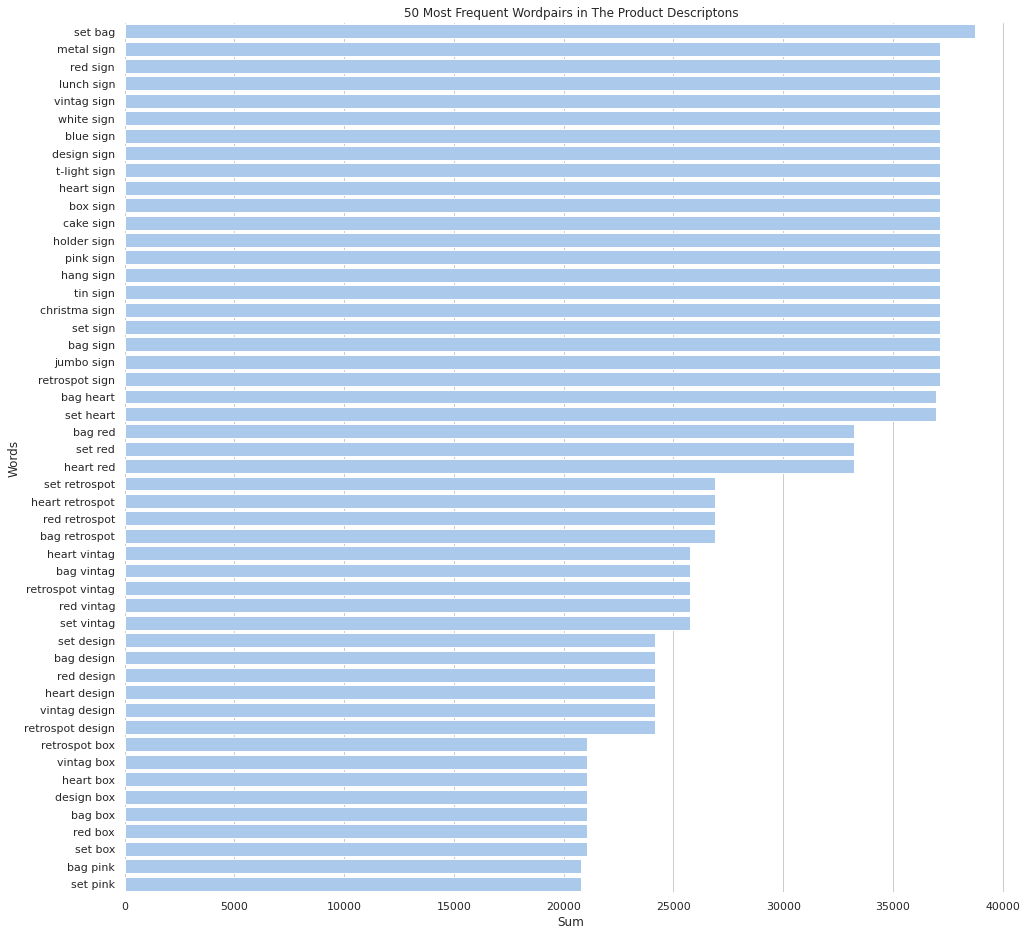

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 16))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x=most_frequesnt_wordpairs["Sum"], y=most_frequesnt_wordpairs["Words"], data=Count, color="b").set_title("50 Most Frequent Wordpairs in The Product Descriptons")
sns.despine(left=True, bottom=True)

The 50 most frequent words and wordpairs in the description suggests that the most frequently purchased products fall into categories like: </br>
</br>
        - Christmas</br>
                                              - Gifts</br>
                                              - Interior accessories</br>
                                              - Gardening</br>
                                              - Bags</br>
                                              </br>
                                              We can assume that a big chunk of these products are mostly in lower price range and relates to impulsive shopping. That is why we should carry out market basket analysis on this dataset, which provides useful information on how we should organize and manage marketing communication including product placement, point of sales advertising and bundling. Besides market basket analysis we can consider connecting well performing categories with those low performing ones which has potential to be purchased better. </br>
                                              </br>

                                            

                                        
                                              

5.) MARKET BASKET ANALYSIS</br>
</br>
It is important to get to know the buying patterns of the customers and promote cross selling of various products</br>
</br>
I determine ASSOCIATION rules, ANTICEDENT AND CONSEQUENT elements, and </br>calculate SUPPORT, CONFIDENCE and LIFT indicators, which provide useful </br>information for the companies to plan their marketing strategy in fields like:</br>
</br>
- Product placement</br>
- Promotional discount</br>
- POS (point of sales) advertisement</br>
- Product boundling</br>
- ANTICEDENT AND CONSEQUENT products can be combined to a new product</br>

In [ ]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
# Delete cancellation

df_initial3=df_initial.copy(deep=True)
df_initial3["Cancellation"]=df_initial3['InvoiceNo'].apply(lambda x: int("C" in x))
df_initial3=df_initial3.drop(df_initial3.index[df_initial3["Cancellation"] == 1])


In [ ]:
# Collect products per invoices

df_initial2=df_initial.copy(deep=True)
df_initial2["Cancellation"]=df_initial2['InvoiceNo'].apply(lambda x: int("C" in x))
df_initial2=df_initial2.drop(df_initial2.index[df_initial2["Cancellation"] == 1])
df_initial2["Description"]=pd.DataFrame(df_initial2["Description"].apply(lambda x: x.lstrip()))



df=pd.DataFrame(df_initial2.groupby(by=['InvoiceNo'])["Description"].apply(lambda x: "ÖÖÖÜÜÜ ".join(x)))




In [ ]:
df["Description"]=df["Description"].apply(lambda x: x.split("ÖÖÖÜÜÜ "))


In [ ]:
df2=df['Description'].values.tolist()

In [ ]:
df2[0]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER']

In [ ]:
#Calculating the key metrics (SUPPORT, CONFIDENCE, LIFT) for the association rules

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules




In [ ]:
encoder=TransactionEncoder().fit(df2)
onehot=encoder.transform(df2)
onehot=pd.DataFrame(onehot, columns=encoder.columns_)



Calculationg the support with 0.02 threshold

In [ ]:
frequent_itemsets=apriori(onehot, min_support=0.02, use_colnames=True)
print(frequent_itemsets)

      support                                           itemsets
0    0.021688                         (3 STRIPEY MICE FELTCRAFT)
1    0.039167                           (6 RIBBONS RUSTIC CHARM)
2    0.025140                  (60 CAKE CASES VINTAGE CHRISTMAS)
3    0.035445                      (60 TEATIME FAIRY CAKE CASES)
4    0.027028                   (72 SWEETHEART FAIRY CAKE CASES)
..        ...                                                ...
238  0.023522  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...
239  0.024547  (WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI...
240  0.022659  (ROSES REGENCY TEACUP AND SAUCER , REGENCY CAK...
241  0.025248  (WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...
242  0.021040  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...

[243 rows x 2 columns]


Calculating the Support, Confidence and Lift figures when the Lift threshold is 1, provides useful information when planning the product placement and advertising. I like to use lift as threshold, its figures above 1 shows that probability of the given association is higher than random.</br> In the table you can see if a consumer buy product/products "antecendents" the probability they will buy "consequents" product is higher then random. So these associations should be considered when planning product placement, POS advertisment, bundling etc.

In [ ]:
rules=association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042566,0.047313,0.028593,0.671736,14.197612,0.026579,2.902200
1,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047313,0.042566,0.028593,0.604333,14.197612,0.026579,2.419798
2,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE PINK),0.047313,0.033071,0.021364,0.451539,13.653725,0.019799,1.762987
3,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.033071,0.047313,0.021364,0.646003,13.653725,0.019799,2.691230
4,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.033233,0.037980,0.022874,0.688312,18.122934,0.021612,3.086480
...,...,...,...,...,...,...,...,...,...
71,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024817,0.042242,0.021040,0.847826,20.070631,0.019992,6.293837
72,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,0.020163,9.124923
73,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.037279,0.023522,0.021040,0.564399,23.994742,0.020163,2.241683
74,(ROSES REGENCY TEACUP AND SAUCER ),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.042242,0.024817,0.021040,0.498084,20.070631,0.019992,1.942923


-----------------------------------END OF THE PROJECT---------------------------------

Miscellaneous material - DOESN'T BELONGS TO THE PROJECT DIRECTLY:

In [ ]:
#another way of organizing the dataset for market basket analyis

df_initial

In [ ]:
mybasket=df_initial.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
mybasket

In [ ]:


mybasket=(df_initial.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
mybasket

Revenue Analysis (good method for time series grouping)

In [ ]:
#get total amount spent per invoice
invoice_customer_df=df_initial2.groupby(by=['InvoiceNo', 'InvoiceDate']).agg({'Total amount':sum, 'CustomerID':max, 'Country':max}).reset_index() 

invoice_customer_df.sort_values('Total amount', ascending=False).head()

#Chart for returning customers by month

ax=invoice_customer_df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'), "CustomerID"]).filter(lambda x: len(x)>1).resample('M').nunique()['CustomerID'].plot\
(kind="bar", figsize=(14,5), legend=False, title="Returning Customers by Months", xlabel="Month", ylabel='Number of Customers')
ax.set_xticklabels(("December 2010", "January 2011", "February 2011", "March 2011", "April 2011", "May 2011", "June 2011", "July 2011", "August 2011", "September 2011", "Oktober 2011", "November 2011", "December 2011"), rotation=45)

#Super method for time series but here it doesn't work
returning=invoice_customer_df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'), "CustomerID"]).filter(lambda x: len(x)>1).resample('M').nunique()['CustomerID']

allcustomersbymonth=df_initial2.set_index('InvoiceDate')['CustomerID'].resample("M").nunique()
monthlyreturningratio=(returning/allcustomerbymonth)*100

returningCustExpenditure=invoice_customer_df.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'), "CustomerID"]).filter(lambda x: len(x)>1).resample('M').sum()['Total amount']
allcustomerExpendituresbymonth=df_initial2.set_index('InvoiceDate')['Total amount'].resample("M").sum()
monthlyreturningratio=(returningCustExpenditure/allcustomerExpendituresbymonth)*100

- Finding the word pairs and formations most frequently appear in the descriptions (TRYING OUT SOME ACCELERATION)
</br>


In [ ]:
wordlist=[x for x in count.index]

from itertools import combinations

wordcombinations=[x for x in combinations(wordlist,2)]

wordcomb=pd.DataFrame(wordcombinations)

In [ ]:
wordcomb

,0,1
0,set,bag
1,set,heart
2,set,red
3,set,retrospot
4,set,vintag
...,...,...
1796455,quartz,montan
1796456,quartz,"""z"""
1796457,capiz,montan
1796458,capiz,"""z"""


In [ ]:
optimized_total_list_pd=pd.DataFrame(optimized_total_list)  
optimized_total_list_pd0 = optimized_total_list_pd.fillna(value='#')


In [ ]:
optimized_total_list_pd0["joined"]=optimized_total_list_pd0[0]+optimized_total_list_pd0[1]+optimized_total_list_pd0[2]+optimized_total_list_pd0[3]+optimized_total_list_pd0[4]+optimized_total_list_pd0[5]+optimized_total_list_pd0[6]
optimized_total_list_pd0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401604 entries, 0 to 401603
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       401604 non-null  object
 1   1       401604 non-null  object
 2   2       401604 non-null  object
 3   3       401604 non-null  object
 4   4       401604 non-null  object
 5   5       401604 non-null  object
 6   6       401604 non-null  object
 7   joined  401604 non-null  object
dtypes: object(8)
memory usage: 24.5+ MB


In [ ]:
#Trying to accelerate the panda calculation
#MAP+Function

def get_sum(a, b):
  sum=optimized_total_list_pd0['joined'].str.contains(a and b).sum()
  return sum
wordcomb["Sum"]=map(get_sum, wordcomb[0], wordcomb[1])
#wordcomb["Sum"]=wordcomb[[0, 1]].apply(lambda x: get_sum(x[0], x[1]), axis=1)


#APPLY LAMBDA
#Trying to calculate the appearance of possible word pairs by using apply, lambda function, but on this dataset I gave up after
# 6 hours
%%time

def get_sum(a, b):
  sum=optimized_total_list_pd0['joined'].str.contains(a and b).sum()
  return sum

wordcomb["Sum"]=wordcomb[[0, 1]].apply(lambda x: get_sum(x[0], x[1]), axis=1)

#Trying LAMBDA on a smaller dataset and measure the time

%%time
wordcomb_short=wordcomb.loc[:100, [0, 1]]
def get_sum(a, b):
  sum=optimized_total_list_pd0['joined'].str.contains(a and b).sum()
  return sum

wordcomb_short["Sum"]=wordcomb_short[[0, 1]].apply(lambda x: get_sum(x[0], x[1]), axis=1)

# Trying with SWIFTER, but it takes more time than a simply lambda function
!pip install swifter

import swifter

wordcomb_short=wordcomb.loc[:10, [0, 1]]
wordcomb_short["Sum"]=wordcomb_short[[0, 1]].swifter.apply(lambda x: get_sum(x[0], x[1]), axis=1)


In [ ]:
#Using np vectorization

%%time

wordcomb_short=wordcomb.loc[:10, [0, 1]]
def get_sum(a, b):
  sum=optimized_total_list_pd0['joined'].str.contains(a and b).sum()
  return sum

vfunc = np.vectorize(get_sum)
wordcomb_short["Sum"]=vfunc(wordcomb_short[0], wordcomb_short[1])

#wordcomb_short["Sum"]=wordcomb_short[[0, 1]].apply(lambda x: get_sum(x[0], x[1]), axis=1)

In [ ]:
wordcomb_short=wordcomb.loc[:10, [0, 1]]

def get_sum(a, b):
  print(a.any())
  #count= np.core.defchararray.count(optimized_total_list_pd0['joined'].values, a)
  #count=np.char.count(optimized_total_list_pd0['joined'].values.astype(dtype='<U18'), a.any() and b.any()) 
  #return count

wordcomb_short["Sum"]=get_sum(wordcomb_short[0].values, wordcomb_short[1].values)

In [ ]:
# 2.method with numpy vectorization (converting map object is also very very time consuming)

%%time
def count(a, b):
  count=np.char.count(optimized_total_list_pd0['joined'].values.astype(dtype='<U18'), a and b)
  k=np.sum(count)
  return k

wordcomb["Sum"]=map(count, wordcomb[0].values, wordcomb[1].values)



CPU times: user 20.7 ms, sys: 980 µs, total: 21.7 ms
Wall time: 23.5 ms


In [ ]:
#SARA DASK (somehow it doesn't work)

optimized_total_list_pd0.replace(to_replace ="#",
                 value ="0")
optimized_total_list_pd0

!pip install "dask[dataframe]" --upgrade
import dask.dataframe as dd
ddf=dd.from_pandas(wordcomb, npartitions=4)

ddf2=dd.from_pandas(optimized_total_list_pd0, npartitions=4)

ddf2.head()

ddf2.describe()

optimized_total_list_pd0[0]
optimized_total_list_pd0[1]
optimized_total_list_pd0['joined'][0].str.contains(optimized_total_list_pd0[0][0])

def converter(x):
    if isinstance(x, pd.Series):
        return tuple(x.values)
    else:
        return x

res = optimized_total_list_pd0[0].apply(converter).unique()

print(res)


%%time


def get_sum(wordcomb):
  sum=ddf2['joined'].str.contains(ddf[0] and ddf[1]).sum()
  return sum

ddf["Sum"]=ddf.apply(get_sum, meta=(None, 'float64'), axis=1)


ddf.persist()

ddf.columns

for x in ddf['Sum'].compute():
  print(x)

In [ ]:
def my_encode_units(x):
  if x<=0:
   return 0
  if x>=1:
    return 1

my_basket_sets=mybasket.applymap(my_encode_units)

my_requent_itemsets=apriori(my_basket_sets, min_support=0.02, use_colnames=True)
my_rules=association_rules(my_requent_itemsets, metric="lift", min_threshold=1)
my_rules

In [ ]:
#Create token for the  words in the descriptions

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=4000, oov_token="<OOV>") #create instance num_words applies to the sequence, OOV is used for words there aren't in the indexlist
tokenizer.fit_on_texts(tt)  # encodes the data, create the dict
word_index = tokenizer.word_index 
seq = tokenizer.texts_to_sequences(tt)
len(seq)


3896

In [ ]:
tokenizer.fit_on_texts(total_description_list)
#word_index = tokenizer.word_index 
seq_total_description = tokenizer.texts_to_sequences(total_description_list)
len(seq_total_description)

401604

In [ ]:
preps=['above', 'across', 'against', 'along', 'among', 'around', 'at','i' 
'before', 'behind', 'below', 'beneath', 'beside', 'between', 'by', 
'down', 'from', 'in', 'into', 'near', 'of', 'off', 'or', 'on', 'to', 'toward', 'under', 'upon', 'with', 'and', 'within']

#def get_key(val):
for key, value in word_index.items():
      if key in preps:
        print(value)
        


In [ ]:


#seq2=[x for x in seq if len(x)>=4]

unwanted_elements=[230, 5, 39, 36, 165, 607, 827, 1289, 1589 ]  
cleared_seq=[]
for k in seq:
  a=[x for x in k if x not in unwanted_elements]
  cleared_seq.append(a)
len(cleared_seq)

3896

In [ ]:
unwanted_elements=[230, 5, 39, 36, 165, 607, 827, 1289, 1589 ]  
cleared_seq_total_description=[]
for k in seq_total_description:
  a=[x for x in k if x not in unwanted_elements]
  cleared_seq_total_description.append(a)
len(cleared_seq_total_description)

401604

In [ ]:
df_tokens=pd.DataFrame(cleared_seq_total_description)
count=df_tokens[0].value_counts()
total_description_list_pd=pd.DataFrame(total_description_list)
total_description_list_pd
count=total_description_list_pd.stack().value_counts()
count


In [ ]:
df_tokens=pd.DataFrame(cleared_seq_total_description)
#df_tokens=df_tokens.fillna(0)
#df_tokens
count=df_tokens.stack().value_counts()
count=list(count[:50].index)
count
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
lista=[]
for i in count:
  lista.append(reverse_word_map.get(i))

lista



In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    final_list=[]
    for i in list_of_indices:
      words = [reverse_word_map.get(letter) for letter in i]
      final_list.append(words)
    return(final_list)


most_common_expressions_towords=sequence_to_text(count)
most_common_expressions_towords

In [ ]:
set(cleared_seq[0]).intersection(cleared_seq[1])

In [ ]:
# most frequent word formations in the descriptions

most_common_expressions=[]



for i in cleared_seq:
  for k in cleared_seq:
    intersection=set(i).intersection(k)
  #  unwanted_elements=[230, 5, 39, 36, 827, 1600 ]
    # cleared_i=[x for x in i if x not in unwanted_elements]
  # cleared_intersection=[x for x in intersection if x not in unwanted_elements]
    if cleared_seq.index(i)!=cleared_seq.index(k) and len(intersection)>=2 and intersection not in most_common_expressions:
        most_common_expressions.append(intersection)


most_common_expressions


In [ ]:
most_common_expressions

In [ ]:
# Untokenizing the most frequent wordformations

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    final_list=[]
    for i in list_of_indices:
      words = [reverse_word_map.get(letter) for letter in i]
      final_list.append(words)
    return(final_list)


most_common_expressions_towords=sequence_to_text(most_common_expressions)
most_common_expressions_towords

In [ ]:
# make the splitted original description to lower case

k=t.tolist()
lower_case_original_list=[]
for i in k:
  lower_case_original_list.append([x.lower() for x in i])
lower_case_original_list

In [ ]:
# make the original description
k=df_initial.Description.str.split(" ")
h=k.tolist()
lower_case_original_list=[]
for i in h:
  p=[]
  for k in i:
    p.append(k.lower())
  lower_case_original_list.append(p)
lower_case_original_list

In [ ]:
# Creating the final list with the most frequent word formation with their occurance

Final_list=[]

most_common_expressions_towords
for k in most_common_expressions_towords:
  counter=0
  for i in lower_case_original_list:
    result = all(elem in i for elem in k)
    if result==True:
      counter +=1
  Final_list.append([k, counter])
 

Final_list


In [ ]:
lower_case_original_list[0]

['white', 'hanging', 'heart', 't-light', 'holder']

In [ ]:
for i in Final_list:

  if i[0]==['heart']:
   print(i[1])

In [ ]:
import copy
Final_list2=copy.deepcopy(Final_list)

The_50_most_frequent_workdformation=[]

for i in range(50):
  max=0
  for i in range(len(Final_list2)):
    if Final_list2[i][1]>max:
      max=Final_list2[i][1]
  
  for q in range(len(Final_list2)):
    if Final_list2[q][1]==max:

      The_50_most_frequent_workdformation.append([Final_list2[q][0], max])
      Final_list2.remove(Final_list2[q])
      break
  #for k in range(len(Final_list2)):
    ##print(Final_list2[k][1], '------', Final_list2[k][1])
   # if Final_list2[k][1]==max:
      ##print(Final_list2[k],"-----",Final_list2[k][1], "----------", max)
    #  Final_list2.remove(Final_list2[k])
     # break
    
The_50_most_frequent_workdformation

In [ ]:
a1=[]
a2=[]
lista=[]
for k in range(50):
  lista.append(k)

for i in The_50_most_frequent_workdformation:
  a1.append(i[0])
  a2.append(i[1])


In [ ]:
afinal=[]
for i in a1:
  u=' | '.join(i)
  afinal.append(u)


cols = {"Number of Occurences": a2, "Words": afinal}
mostfrequentwords=pd.DataFrame(data=cols)
mostfrequentwords





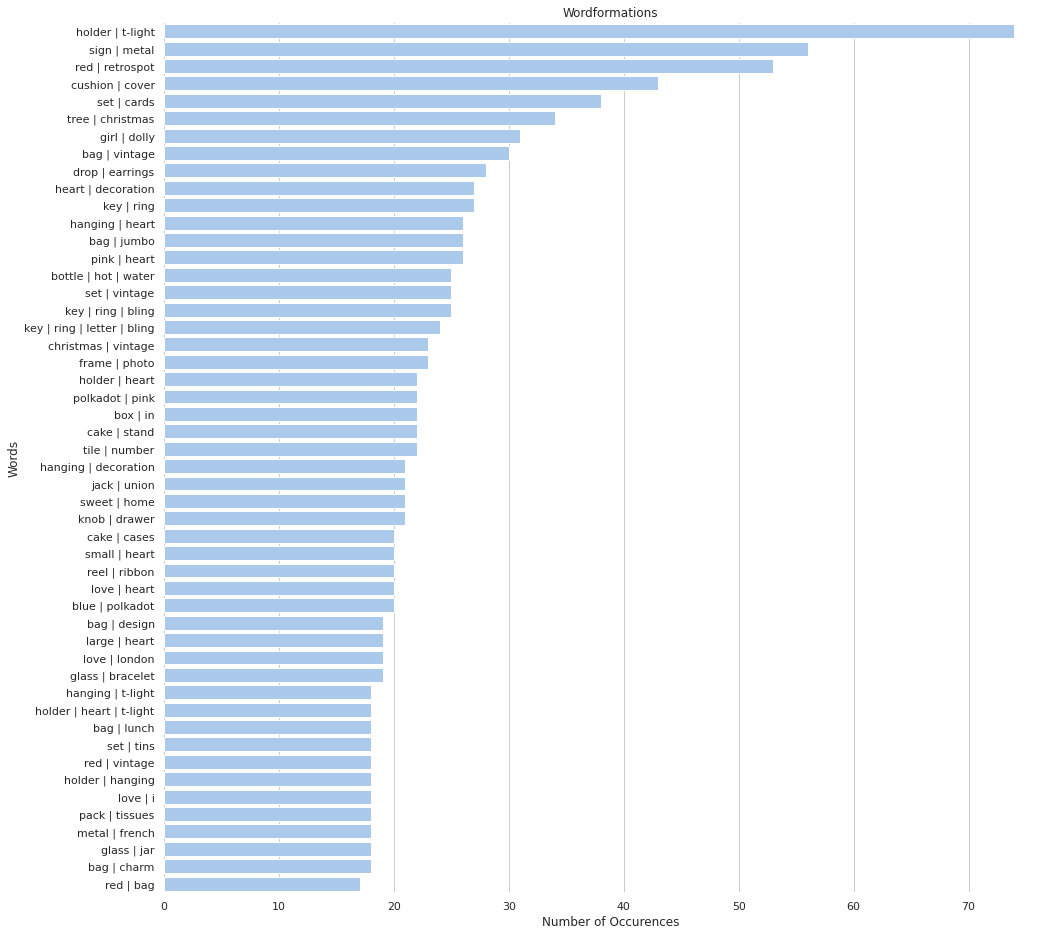

In [ ]:
import seaborn as sns

plt.figure(figsize=(16, 16))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x=mostfrequentwords["Number of Occurences"], y=mostfrequentwords.Words, data=mostfrequentwords, color="b").set_title("Wordformations")
sns.despine(left=True, bottom=True)

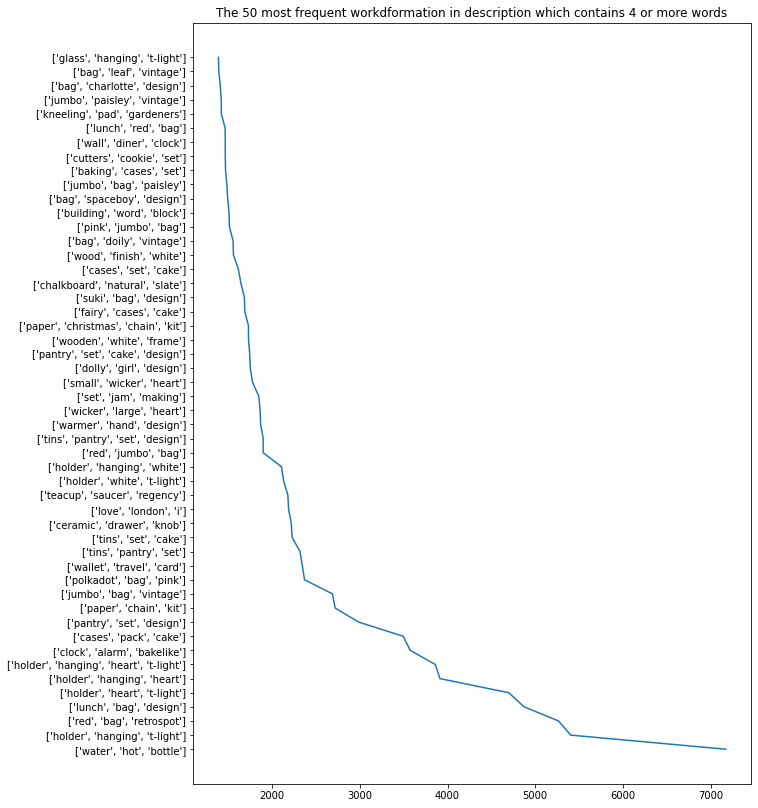

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10,14) 
y = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49])
x = np.array(a2)
my_yticks = a1
plt.yticks(y, my_yticks)
plt.plot(x, y)
plt.title("The 50 most frequent workdformation in description which contains 3 or more words")
plt.show()

